In [1]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchvision import tv_tensors
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import torch.optim as optim
import torchvision

cuda = torch.cuda.is_available()

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.2.1+cu118  Device: cuda


In [2]:
negative_csv = 'CADDY_gestures_all_true_negatives_release_v2.csv'
positive_csv = 'CADDY_gestures_all_true_positives_release_v2.csv'

In [3]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
print("Parent Directory:", parent_directory)

img_directory = os.path.join(parent_directory, 'data', 'raw')

Parent Directory: C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA904-2024S1\projetos\sinais_mergulhadores


In [4]:
df = pd.read_csv(os.path.join(parent_directory, 'data','raw', positive_csv))
df['stereo left'] = img_directory + df['stereo left']
df['stereo right'] = img_directory + df['stereo right']

df.head()

,index,scenario,stereo left,stereo right,label name,label id,roi left,roi right,synthetic,iqa_mdm_entropy,iqa_mdm_d,iqa_mdm_dcomp,distortion,param 1,param 2
0,0,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",0,6.971026,0.957653,0.902,NaN,NaN,NaN
1,1,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",1,NaN,NaN,NaN,blur,7,NaN
2,2,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",1,NaN,NaN,NaN,blur,11,NaN
3,3,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",1,NaN,NaN,NaN,blur,15,NaN
4,4,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",1,NaN,NaN,NaN,channel noise,5,NaN


In [5]:
df2 = pd.read_csv(os.path.join(parent_directory, 'data', 'raw', negative_csv))
df2['stereo left'] = img_directory + df2['stereo left']
df2['stereo right'] = img_directory + df2['stereo right']

df2.head()

,index,scenario,stereo left,stereo right,selected img,label name,label id,roi params,synthetic,distortion type,dist. param 1,dist. param 2
0,0,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,NaN,true_neg,-1,NaN,0,NaN,NaN,NaN
1,1,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,NaN,true_neg,-1,NaN,1,blur,7,NaN
2,2,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,NaN,true_neg,-1,NaN,1,blur,11,NaN
3,3,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,NaN,true_neg,-1,NaN,1,blur,15,NaN
4,4,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,NaN,true_neg,-1,NaN,1,channel noise,5,NaN


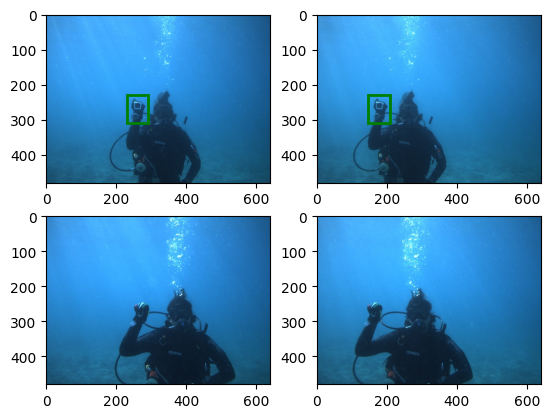

(480, 640, 3)


In [6]:
import matplotlib.patches as patches

fig, ax = plt.subplots(2,2)
for i, side in enumerate(['left','right']):
    test_image = df.iloc[10]['stereo '+side]
    roi_coords = df.iloc[10]['roi '+side][1:-1]
    top_row, top_column, width, height = roi_coords.split(',')
    
    img = cv2.imread(test_image)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    rectangle = patches.Rectangle((int(top_row), int(top_column)), int(width), int(height), edgecolor='g', linewidth=2, fill=False)
        
    ax[0,i].imshow(rgb)
    ax[0,i].add_patch(rectangle)

for i, side in enumerate(['left','right']):
    test_image = df2.iloc[10]['stereo '+side]
    
    img = cv2.imread(test_image)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    ax[1,i].imshow(rgb)
    
plt.show()

print(img.shape)

In [7]:
#Seleting raw stereo photos
raw_df = df[df['iqa_mdm_entropy'].notnull()].reset_index(drop=True)
raw_df2 = df2[df2['synthetic']==0].reset_index(drop=True)

#Filling in nan values
raw_df.loc[:,'roi left'] = raw_df['roi left'].fillna(str([-1,-1,0,0]))
raw_df.loc[:,'roi right'] = raw_df['roi right'].fillna(str([-1,-1,0,0]))

#Modifying label id in negative df
raw_df2['label id'] = 16

In [8]:
from sklearn.model_selection import train_test_split

trainval_df, test_df = train_test_split(raw_df,test_size=0.2, stratify=raw_df['label id'],random_state=42)
train_df, val_df = train_test_split(trainval_df,test_size=0.2, stratify=trainval_df['label id'], random_state=42)

trainval_df2, test_df2 = train_test_split(raw_df2,test_size=0.2, random_state=42)
train_df2, val_df2 = train_test_split(trainval_df2,test_size=0.2, random_state=42)

pos_train_df = train_df.reset_index(drop=True)
pos_val_df   = val_df.reset_index(drop=True)
pos_test_df  = test_df.reset_index(drop=True)

neg_train_df = train_df2.reset_index(drop=True)
neg_val_df   = val_df2.reset_index(drop=True)
neg_test_df  = test_df2.reset_index(drop=True)

print('Training mini-dataset:', len(pos_train_df)+len(neg_train_df))
print('Validation mini-dataset:', len(pos_val_df)+len(neg_val_df))
print('Testing mini-dataset:', len(pos_test_df)+len(neg_test_df))

Training mini-dataset: 10513
Validation mini-dataset: 2630
Testing mini-dataset: 3286


In [9]:
class ImageDataset(Dataset):
    def __init__(self, pos_dataframe: pd.DataFrame, neg_dataframe: pd.DataFrame, transform=None):
        self.pos_df = pos_dataframe
        self.neg_df = neg_dataframe
        self.transform = transform
        self.paths = pd.concat((self.pos_df['stereo left'], self.neg_df['stereo left']), axis = 0).values
        self.labels = pd.concat((self.pos_df['label id'], self.neg_df['label id']), axis = 0).values
            
    def normalize(self, image_arr: np.ndarray):
        return (image_arr - image_arr.min()) / (image_arr.max() - image_arr.min())
                
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index: int):
        x = self.normalize(np.asarray(Image.open(self.paths[index])))
        y = self.labels[index]
        if self.transform:
            x = self.transform(x)
        return x, y

In [10]:
train_transform = transforms.Compose([transforms.ToImage(),
                                    transforms.ToDtype(torch.float32, scale=True),
                                    transforms.RandomZoomOut(p=0.25),
                                    transforms.RandomRotation(degrees=(0,20)),
                                    transforms.RandomPerspective(),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.GaussianBlur(kernel_size=(3,3)),
                                    transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                    transforms.Resize((160,212))])
                                    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

valtest_transform = transforms.Compose([transforms.ToImage(), 
                                        transforms.ToDtype(torch.float32, scale=True)])
#                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_ds = ImageDataset(pos_train_df, neg_train_df, transform=train_transform)
val_ds   = ImageDataset(pos_val_df, neg_val_df, transform=valtest_transform)
test_ds  = ImageDataset(pos_test_df, neg_test_df, transform=valtest_transform)

In [11]:
classes, counts = np.unique(train_ds.labels, return_counts=True)
total_samples = int(sum(counts))

print(classes)

imbalance_weights = [total_samples / (len(counts) * count) for count in counts]
weights = torch.tensor(imbalance_weights, dtype=torch.float).to(device)
print('Unbalanced weights:',weights)

class_weights = np.array([1/count for count in counts])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Unbalanced weights: tensor([ 0.5308,  0.7336,  2.7363,  2.0892,  1.0446,  1.7226,  1.3473,  2.6204,
         3.7031,  4.2649,  0.9754,  6.0040,  2.3969,  2.4936,  4.1227, 19.9488,
         0.1344], device='cuda:0')


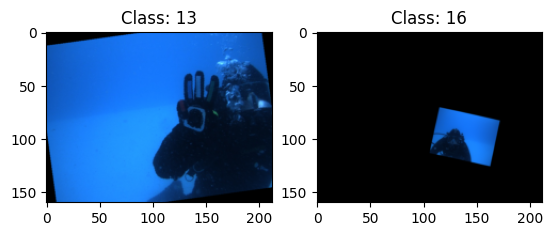

In [12]:
fig, ax = plt.subplots(1,2)
img, label = train_ds[0]
img = img.numpy().transpose((1, 2, 0))
img_normalized = img / np.max(img)
ax[0].imshow(img_normalized)
ax[0].set_title('Class: {}'.format(label))
img, label = train_ds[-1]
img = img.numpy().transpose((1, 2, 0))
img_normalized = img / np.max(img)
ax[1].imshow(img_normalized)
ax[1].set_title('Class: {}'.format(label))
plt.show()

In [13]:
np.min(img), np.max(img), np.mean(img), np.std(img)

(0.0, 0.99765396, 0.027885148, 0.13179466)

In [14]:
weights_ds = np.zeros(total_samples)
for idx, sample in enumerate(weights_ds):
    weights_ds[idx] = class_weights[train_ds.labels[idx]]

In [15]:
from torch.utils.data.sampler import WeightedRandomSampler

sampler = WeightedRandomSampler(weights_ds, len(train_ds), replacement=True)

In [16]:
batch_size = 64

train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False)

In [17]:
num_classes = 17
# Load pre-trained SqueezeNet model
model = torchvision.models.squeezenet1_0()#weights='SqueezeNet1_0_Weights.DEFAULT'

# Freeze all layers except the final classifier
#for param in model.parameters():
#    param.requires_grad = False

# Replace the classifier with a new one
model.classifier[1] = torch.nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
model = model.to(device)
summary(model, (3, 160, 212))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 96, 77, 103]          14,208
              ReLU-2          [-1, 96, 77, 103]               0
         MaxPool2d-3           [-1, 96, 38, 51]               0
            Conv2d-4           [-1, 16, 38, 51]           1,552
              ReLU-5           [-1, 16, 38, 51]               0
            Conv2d-6           [-1, 64, 38, 51]           1,088
              ReLU-7           [-1, 64, 38, 51]               0
            Conv2d-8           [-1, 64, 38, 51]           9,280
              ReLU-9           [-1, 64, 38, 51]               0
             Fire-10          [-1, 128, 38, 51]               0
           Conv2d-11           [-1, 16, 38, 51]           2,064
             ReLU-12           [-1, 16, 38, 51]               0
           Conv2d-13           [-1, 64, 38, 51]           1,088
             ReLU-14           [-1, 64,

In [18]:
# Define your loss function
criterion = torch.nn.CrossEntropyLoss()#weight=weights
# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

torch.cuda.empty_cache()
train_loss_list = []
val_loss_list = []
train_acc = []
val_acc = []
num_epochs = 25
# Assuming you have a DataLoader for your dataset called 'train_loader'
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        optimizer.step()
        # Add up performance on current batch
        running_loss += loss.item()* inputs.size(0)
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    # Calculate training accuracy and loss
    train_accuracy = correct_train / total_train
    train_loss = running_loss/len(train_loader.dataset)
    train_acc.append(train_accuracy)
    train_loss_list.append(train_loss)
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)  # sum up batch loss
             # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Calculate validation accuracy and loss
    val_loss = val_loss / len(validation_loader.dataset)    
    val_accuracy = correct / total
    val_acc.append(val_accuracy)
    val_loss_list.append(val_loss)
    # Print loss and performance values per epoch
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2%}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2%}")

Epoch 1/25, Train Loss: 2.8336, Train Accuracy: 5.95%, Val Loss: 2.8342, Val Accuracy: 2.36%
Epoch 2/25, Train Loss: 2.8333, Train Accuracy: 5.98%, Val Loss: 2.8333, Val Accuracy: 1.37%
Epoch 3/25, Train Loss: 2.8332, Train Accuracy: 6.41%, Val Loss: 2.8361, Val Accuracy: 1.37%
Epoch 4/25, Train Loss: 2.8333, Train Accuracy: 5.78%, Val Loss: 2.8356, Val Accuracy: 2.36%


KeyboardInterrupt: 

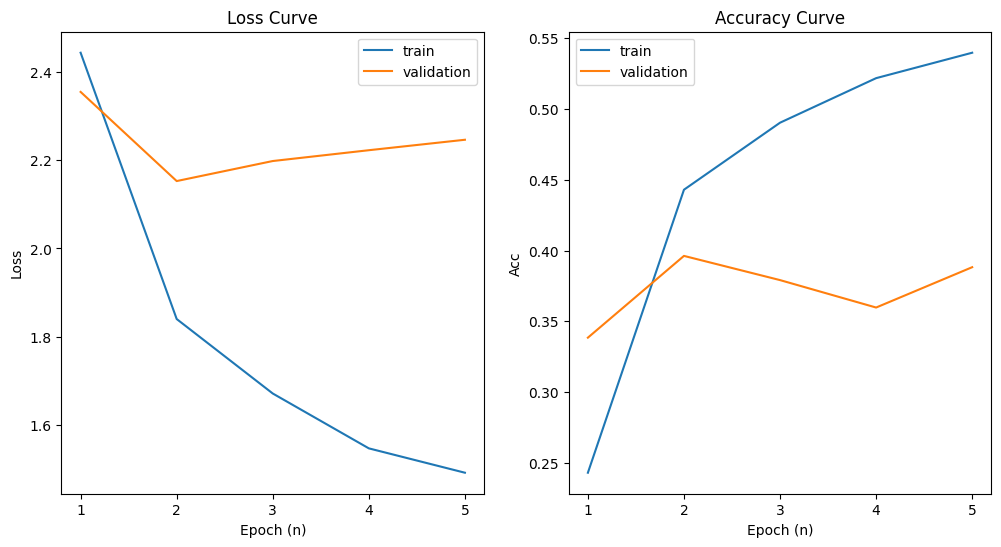

In [19]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(range(1,5+1), train_loss_list, label='train')
plt.plot(range(1,5+1), val_loss_list, label='validation')
plt.legend()
plt.xlabel('Epoch (n)')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.xticks(range(1,5+1, 1))
plt.subplot(122)
plt.plot(range(1,5+1), train_acc, label='train')
plt.plot(range(1,5+1), val_acc, label='validation')
plt.title('Accuracy Curve')
plt.xlabel('Epoch (n)')
plt.ylabel('Acc')
plt.xticks(range(1,5+1, 1))
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import classification_report

#Testing on outside dataset
model.eval()
test_loss = 0.0
correct = 0
total = 0

pred = np.zeros(len(test_loader.dataset))
true = np.zeros(len(test_loader.dataset))

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)  # sum up batch loss
         # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        iter_size = labels.size(0)
        pred[i*batch_size:i*batch_size+iter_size] = predicted.detach().cpu().numpy()
        true[i*batch_size:i*batch_size+iter_size] = labels.detach().cpu().numpy()
test_loss = val_loss / len(validation_loader.dataset)
# Calculate validation accuracy
test_accuracy = correct / total
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.2%}')

# Generate classification report
report = classification_report(true, pred)

# Print the classification report
print(report)


Test loss: 3.5422
Test accuracy: 2.37%
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       364
         1.0       0.00      0.00      0.00       264
         2.0       0.00      0.00      0.00        70
         3.0       0.00      0.00      0.00        92
         4.0       0.00      0.00      0.00       185
         5.0       0.00      0.00      0.00       112
         6.0       0.00      0.00      0.00       143
         7.0       0.00      0.00      0.00        74
         8.0       0.00      0.00      0.00        52
         9.0       0.00      0.00      0.00        45
        10.0       0.00      0.00      0.00       199
        11.0       0.00      0.00      0.00        32
        12.0       0.00      0.00      0.00        81
        13.0       0.02      1.00      0.05        78
        14.0       0.00      0.00      0.00        47
        15.0       0.00      0.00      0.00        10
        16.0       0.00      0.00      0.0

C:\Users\jazg2\miniconda3\envs\RL-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jazg2\miniconda3\envs\RL-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jazg2\miniconda3\envs\RL-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


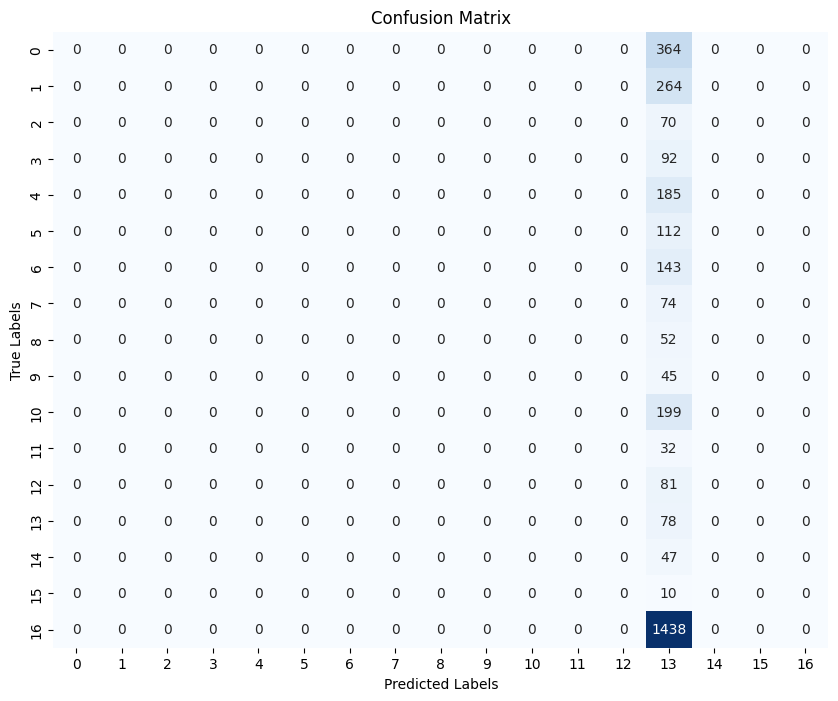

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(true, pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()